In [3]:
datadir = '../../Datasets/'
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from sklearn.linear_model import LinearRegression
from collections import Counter

## Some useful functions

* deg_corr: compute $k_{nn}(l)$ for all degrees $l$, as defined in section 4.3 (undirected)
* deg_corr_directed: compute $k_{nn}^{mode1,mode2}(l)$ for all degrees $l$, as defined in section 4.5; mode1 and mode2 can be 'in', 'out' or 'all'
* deg_corr_neutral: for neutral graph with same degree distribution as in G
* corr_exp: correlation exponent via linear regression (taking logs) as in section 4.3
* rich_club: rich club coefficient (section 4.3) for a given degree $l$

In [4]:
## Degree correlation functions

# undirected
def deg_corr(G):
    deg_set = set(G.degree())
    deg_list = list(deg_set)
    deg_list.sort()

    idx = {v:k for k,v in enumerate([i for i in deg_list])}    
    idx_inv = {k:v for k,v in enumerate(idx)}        
    deg = G.degree()    
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graph with degree distribution in G
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    

## k_nn^{mode1,mode2}(l) : average mode2-degree of mode1-neighbours of nodes with mode1-degree = l
def deg_corr_directed(G, mode1='all', mode2='all'):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree(mode=mode1))])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree(mode=mode2)
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in G.neighbors(v, mode='out')] ## do each link only once
        L[idx[v.degree(mode=mode1)]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L)) if len(L[i])>0}

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()      
    
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

## for a fixed l -- can be slow for multiple l's
def rich_club(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat     


Q1:
For each of the three GitHub Developers graphs (the ml developers,
the web developers, and the original one), do the following:

a. plot the degree correlation function knn(l) and its uncorrelated
counterpart ^knn(l);

b. Find the degree correlation coefficient r,

c. Find the correlation exponent miu,

d. plot the rich-club coefficient p(l).

In [5]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

#Remove isolated nodes from ml and web subgraphs.
gh_ml.vs.select(_degree=0).delete()
gh_web.vs.select(_degree=0).delete()
print('No isolates ml developers:',gh_ml.vcount(),'; No isolates web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961
No isolates ml developers: 7431 ; No isolates web developers: 27676


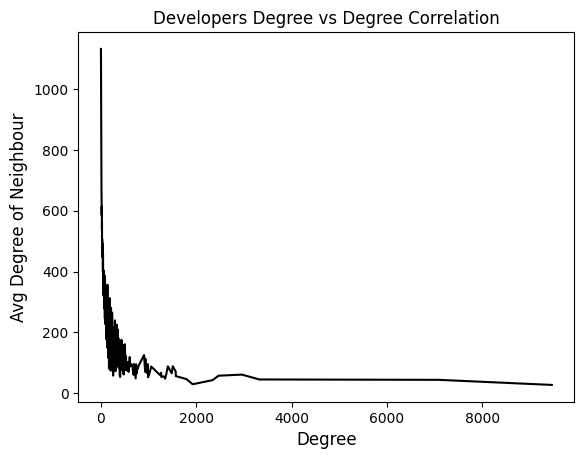

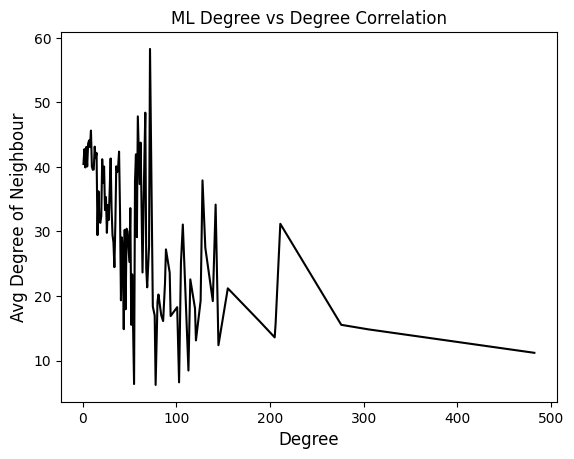

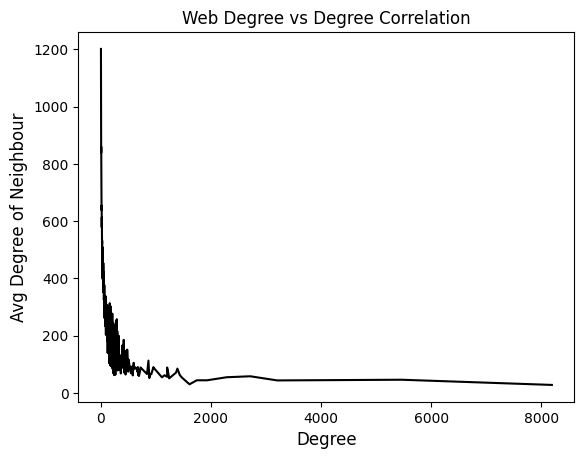

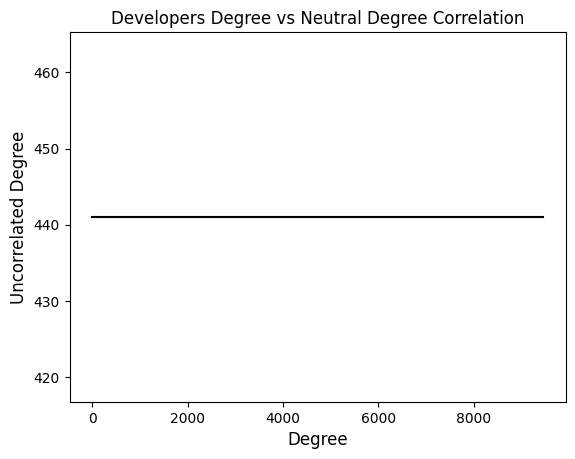

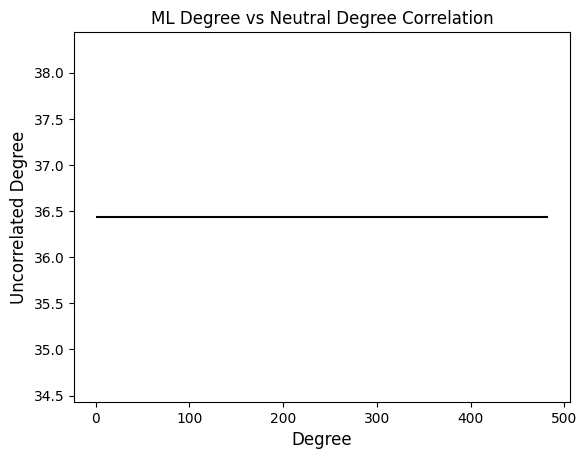

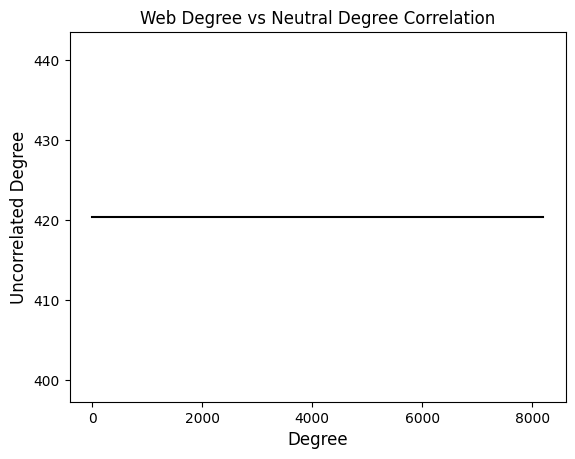

In [6]:
# a) plot the degree correlation function knn(l) and its uncorrelated counterpart ^knn(l);
def plot_deg_correlation(gr, title):
    output = deg_corr(gr)
    degree = []
    neighbour_avg_degree = []    
    for key in output:
        degree.append(key)
        neighbour_avg_degree.append(output[key])

    plt.plot(degree, neighbour_avg_degree, color='black')
    plt.title(f"{title}")
    plt.xlabel('Degree',fontsize=12)
    plt.ylabel('Avg Degree of Neighbour',fontsize=12)
    plt.show()

def plot_deg_correlation_neutral(gr, title):
    degrees = deg_corr(gr).keys()
    output = deg_corr_neutral(gr)
    uncorrelated_correlation = np.ones(len(degrees))*output    

    plt.plot(degrees, uncorrelated_correlation, color='black')
    plt.title(f"{title}")
    plt.xlabel('Degree',fontsize=12)
    plt.ylabel('Uncorrelated Degree',fontsize=12)
    plt.show()

plot_deg_correlation(gh, "Developers Degree vs Degree Correlation")
plot_deg_correlation(gh_ml, "ML Degree vs Degree Correlation")
plot_deg_correlation(gh_web, "Web Degree vs Degree Correlation")
plot_deg_correlation_neutral(gh,  "Developers Degree vs Neutral Degree Correlation")
plot_deg_correlation_neutral(gh_ml, "ML Degree vs Neutral Degree Correlation")
plot_deg_correlation_neutral(gh_web, "Web Degree vs Neutral Degree Correlation")

In [7]:
# b. Find the degree correlation coefficient r,
print("test")
r_gh = gh.assortativity_degree()
r_gh_web = gh_web.assortativity_degree()
r_gh_ml = gh_ml.assortativity_degree()

print(f"full degree correlation {r_gh}\nml degree correlation {r_gh_ml} \nweb degree correlation {r_gh_web}\n")

test
full degree correlation -0.07521713413904484
ml degree correlation -0.09098692775064465 
web degree correlation -0.08714757315866849



In [8]:
# c. Find the correlation exponent miu,

#Note: For our linear log regression we will need to drop nodes with 0 degree so our log function can run. 

mu_gh = corr_exp(gh)
print(f"full degree correlation exponent {mu_gh}")
mu_gh_ml = corr_exp(gh_ml)
print(f"ml degree correlation exponent  {mu_gh_ml}")
mu_gh_web = corr_exp(gh_web)
print(f"web degree correlation exponent  {mu_gh_web}")

full degree correlation exponent -0.5076879013701242
ml degree correlation exponent  -0.2514234876818035
web degree correlation exponent  -0.5151040696086918


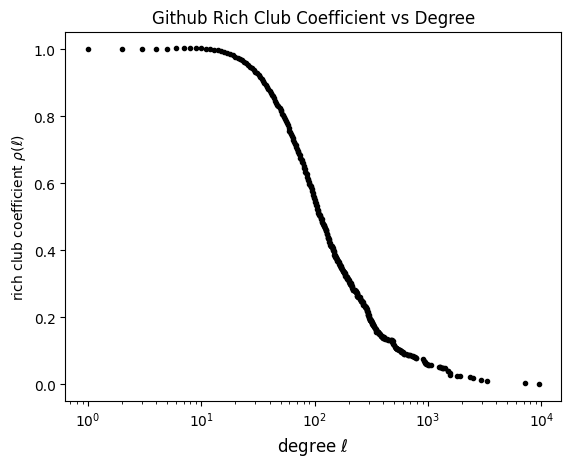

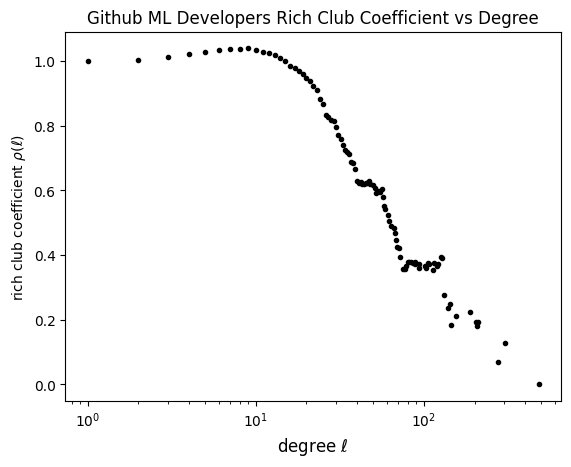

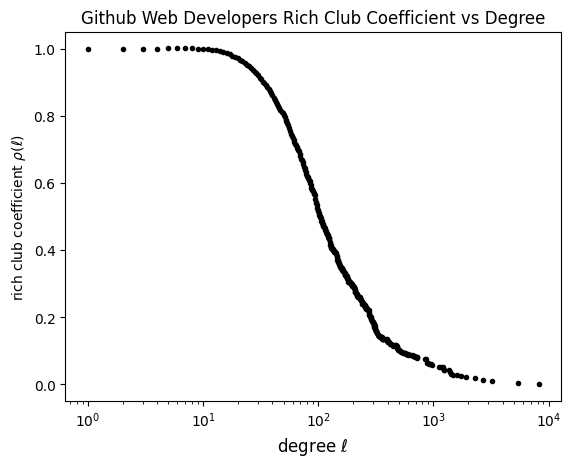

In [9]:
# d. plot the rich-club coefficient p(l).
def get_rc_graph(g, title):
    d = list(set(g.degree()))
    rc = []
    for i in d:
        rc.append(rich_club(g, l=i))
    plt.semilogx(d,rc,'.',c='black')
    plt.title(title)
    plt.xlabel(r'degree $\ell$',fontsize=12)
    plt.ylabel(r'rich club coefficient $\rho(\ell)$');
    plt.show()

get_rc_graph(gh, "Github Rich Club Coefficient vs Degree")
get_rc_graph(gh_ml, "Github ML Developers Rich Club Coefficient vs Degree")
get_rc_graph(gh_web, "Github Web Developers Rich Club Coefficient vs Degree")

Q2: Starting with the original GitHub Developers graph, apply the
switching method to get the randomized degree correlation function
 knn(l). Compare it with the degree correlation function knn(l)
and its uncorrelated counterpart ^knn(l). What is your conclusion?

In [10]:
gh_devs = gh.copy()

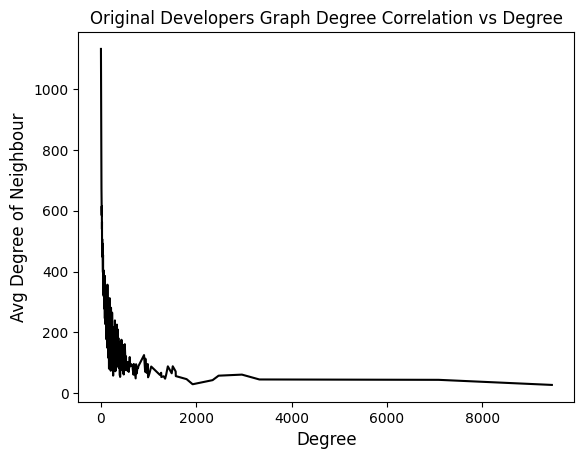

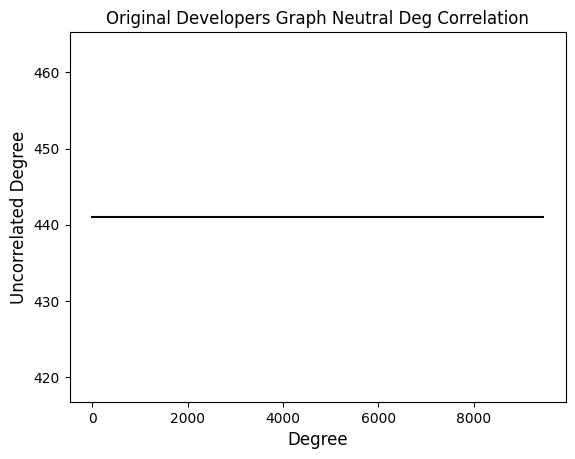

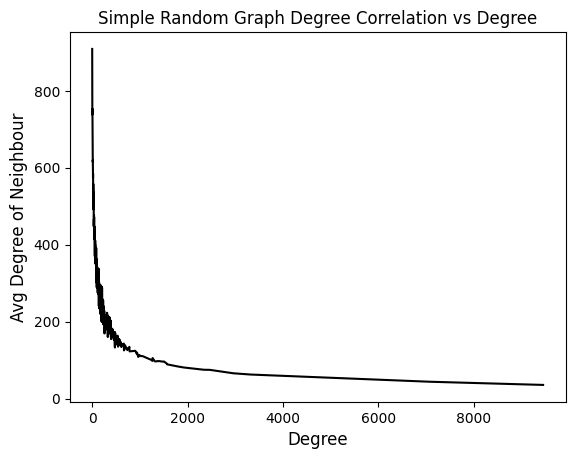

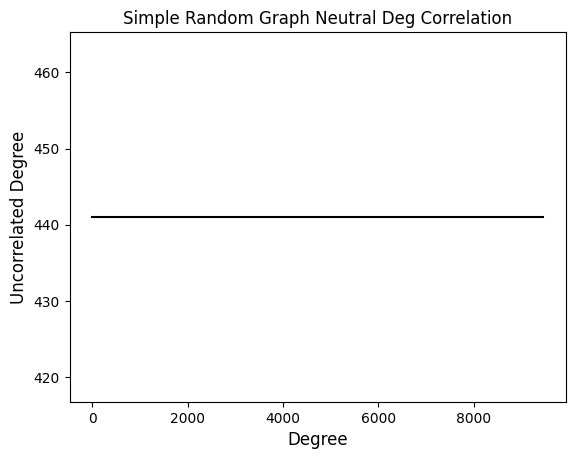

In [11]:
# Need randomized degree correlation function, perform random switching using the built in function, should be sufficient for our purposes.
import random

m = gh_devs.ecount()
random_graph = gh_devs.copy()
random_graph.rewire(m, mode="simple")
plot_deg_correlation(gh_devs, "Original Developers Graph Degree Correlation vs Degree")
plot_deg_correlation_neutral(gh_devs, "Original Developers Graph Neutral Deg Correlation")
plot_deg_correlation(random_graph, "Simple Random Graph Degree Correlation vs Degree")
plot_deg_correlation_neutral(random_graph, "Simple Random Graph Neutral Deg Correlation")


Q2 Answer: From the graphs, we can see the plots for our two graphs are virtually indistinguishable. This indicates our correlations in G are occurring in a way similar to that of a random graph, and that we can consider G an uncorrelated graph.

Q3: Starting with the original GitHub Developers graph, apply the
switching method but instead of waiting for all edges to be switched
at least once, perform only cm edge switchings for c [0.5; 1; 2]
(m is the number of edges). For each experiment, plot the (approximated)
randomized degree correlation function bar_knn(l). Independently
check how many edges have not been switched. (After
cm edge switchings, we randomly switch 2cm edges and theoretical
results imply that we expect e^(-2c) fraction of edges to remain
not switched. You may check if your experiment returns a similar
answer.)

NOTE: For our switching algorithm I used the built-in switch function from igraph. The switching appears to be slightly different to what we expect, but I hope it is still sufficient for our purposes. I did try writing my own algorithm, but on top of it being much slower (over an hour for c = 0.5) it also did not get the expect number of unchanged edges. I have included it for reference. I also attempted to use the Julia functions, but I have never used Julia, and didn't realize we had a switching algorithm until the night before the assignment was due and was not able to get the hang of it in time for the assignment's deadline. The switching algorithm from iGraph does work, I believe it still answers what the question is trying to determine and I have still provided all the information requested by the question, so I hope it is sufficient.

In [12]:
gh_developers = gh.copy()
print(gh_developers.ecount())
print(gh_developers.vcount())

289003
37700


In [13]:
def get_edge_index_dict(g):
    edge_dict = dict()
    for edge in g.es():        
        source = edge.source
        target = edge.target
        edge_dict[edge.index] = (list([source, target]))        

    return edge_dict

def get_edge_set(g):
    edge_set = set()
    for edge in g.es():        
        source = edge.source
        target = edge.target
        edge_set.add(tuple([source, target]))

    return edge_set

def swap_edges(g, edge1_source, edge1_target, edge2_source, edge2_target):
        
    g.add_edges([tuple((edge1_source, edge2_target)), tuple((edge2_source, edge1_target))])    
    g.delete_edges([tuple((edge1_source, edge1_target)), tuple((edge2_source, edge2_target))])
    
def random_switch(g, max_edge_switches): #Not used, quite a large runtime (Over 60 minutes for c = 0.5) but included for reference
    #edge_dict = get_edge_index_dict(g)
    new_edges = set()
    es = g.es()
    max_index = len(es) - 1
    num_edge_switches = 0

    for edge in es:

        if num_edge_switches >= max_edge_switches:
            break
        
        simple = False

        while simple == False: # Reselect until simplicity is preserved
            idx1 = random.randint(0, max_index)
            idx2 = random.randint(0, max_index)

            while idx1 == idx2:
                idx2 = random.randint(0, max_index) #Can't switch edge with itself
            
            old_edge1_source = es[idx1].source
            old_edge1_target = es[idx1].target
            old_edge2_source = es[idx2].source
            old_edge2_target = es[idx2].target

            swap_edges(g, old_edge1_source, old_edge1_target, old_edge2_source, old_edge2_target)            

            simple = g.is_simple()

            if not simple: #Undo change if not simple                
                swap_edges(g, old_edge1_source, old_edge2_target, old_edge2_source, old_edge1_target)
            else:
                num_edge_switches += 2
        
    print(f"Num_edge_switches {num_edge_switches} max_edge_switches: {max_edge_switches}")
    return g

# g1 = ig.Graph([[0, 1], [2, 3]])
# g2 = random_switch(g1, 1)
# print(get_edge_set(g2))
# print(get_edge_set(g1))


edges 289003


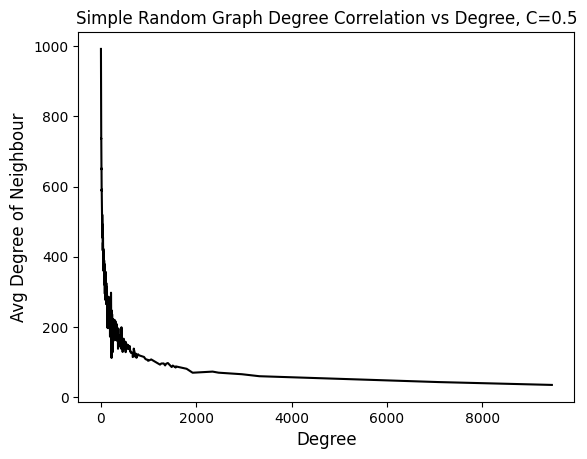

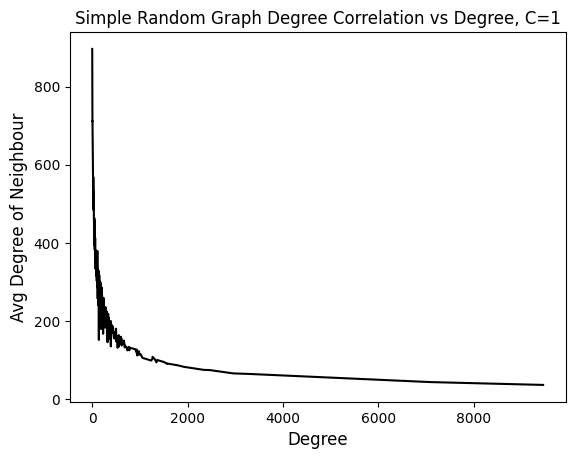

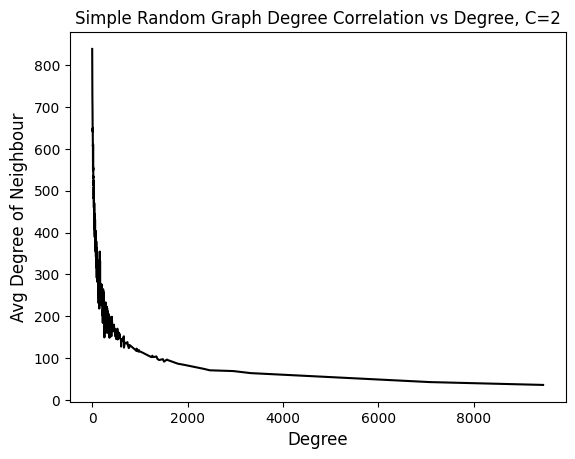

In [14]:
m = gh_developers.ecount()
print(f"edges {m}")
def exp_not_switched_fraction(c):
    return np.exp(-2*c)

def fraction_unchanged(old_edges, new_edges):
    total_unchanged = 0    
    for new_edge in new_edges:
        
        if new_edge in old_edges:
            total_unchanged += 1

    return total_unchanged/len(old_edges)

gh_c_0_5 = gh_developers.copy()
gh_c_1 = gh_developers.copy()
gh_c_2 = gh_developers.copy()

# From igraph, not working as expected but still working
gh_c_0_5.rewire(n = int(0.5*m), mode="simple")
gh_c_1.rewire(n = 1*m, mode="simple")
gh_c_2.rewire(n = 2*m, mode="simple")

#My algorithm, for reference
# gh_c_0_5 = random_switch(gh_c_0_5, int(0.5*m)) #Edge Switches 144502
# gh_c_1 = random_switch(gh_c_1, 1*m)
# gh_c_2 = random_switch(gh_c_2, 2*m)

og_edges = get_edge_set(gh_developers)
c_0_5_edges = get_edge_set(gh_c_0_5)
c_1_edges = get_edge_set(gh_c_1)
c_2_edges = get_edge_set(gh_c_2)

plot_deg_correlation(gh_c_0_5, "Simple Random Graph Degree Correlation vs Degree, C=0.5")
plot_deg_correlation(gh_c_1, "Simple Random Graph Degree Correlation vs Degree, C=1")
plot_deg_correlation(gh_c_2, "Simple Random Graph Degree Correlation vs Degree, C=2")


In [15]:
actual_fraction_c_0_5 = fraction_unchanged(og_edges, c_0_5_edges)
exp_fraction_c_0_5 = exp_not_switched_fraction(0.5)
print(f"C=0.5: Expected unchanged Fraction: {exp_fraction_c_0_5} Actual Unchanged Fraction {actual_fraction_c_0_5}")

actual_fraction_c_1 = fraction_unchanged(og_edges, c_1_edges)
exp_fraction_c_1 = exp_not_switched_fraction(1)
print(f"C=1: Expected unchanged Fraction: {exp_fraction_c_1} Actual Unchanged Fraction {actual_fraction_c_1}")

actual_fraction_c_2 = fraction_unchanged(og_edges, c_2_edges)
exp_fraction_c_2 = exp_not_switched_fraction(2)
print(f"C=2: Expected unchanged Fraction: {exp_fraction_c_2} Actual Unchanged Fraction {actual_fraction_c_2}")

C=0.5: Expected unchanged Fraction: 0.36787944117144233 Actual Unchanged Fraction 0.42800939782632014
C=1: Expected unchanged Fraction: 0.1353352832366127 Actual Unchanged Fraction 0.20314668013826845
C=2: Expected unchanged Fraction: 0.01831563888873418 Actual Unchanged Fraction 0.07439715158666173


From the above cell, it is clear that we do not change as many edges as we expect across all values of C. This is a peculiarity of the igraph switch function, but the numbers are still close enough to demonstrate the trend across our graphs.

Q5: Use the Chung-Lu model with n = 10;000 nodes to generate three
graphs with power law degree distribution (gamma = 2.1, gamma = 2:5, and gamma = 2:9), delta = 1, and max delta = 100. See Figure 2.6. For each of them,
investigate the friendship paradox and rich-club behaviour similarly
as we have done in Figure 4.8.

In [16]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    ## generate edges (tuples), drop collisions, until m edges are obtained.
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i]), 1.0) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops, 1.0 is edge weight
        tples = list(set(tples)) ## drop collisions
    return tples

def generate_cl_graph(gamma, n, delta, Delta):

    ## generate degrees
    W = []
    for i in np.arange(1,n+1):
        W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

    # deg = [int(np.round(w)) for w in W] ## to enforce integer weights, not an obligation
    deg = W

    m = int(np.mean(deg)*n/2)
    tpl = fastCL(deg,m)
    graph = ig.Graph.TupleList(tpl)
    return graph

## power law graph
n = 10000

## min and max degrees
delta = 1
Delta = 100

gamma = 2.1
cl_2_1 = generate_cl_graph(gamma, n, delta, Delta)
gamma = 2.5
cl_2_5 = generate_cl_graph(gamma, n, delta, Delta)
gamma = 2.9
cl_2_9 = generate_cl_graph(gamma, n, delta, Delta)



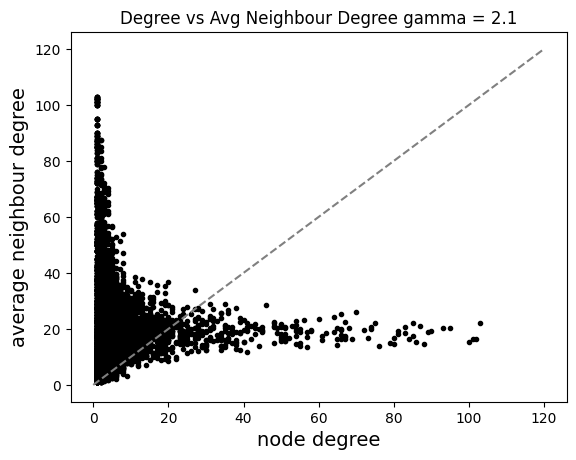

r = -0.013475517738126663


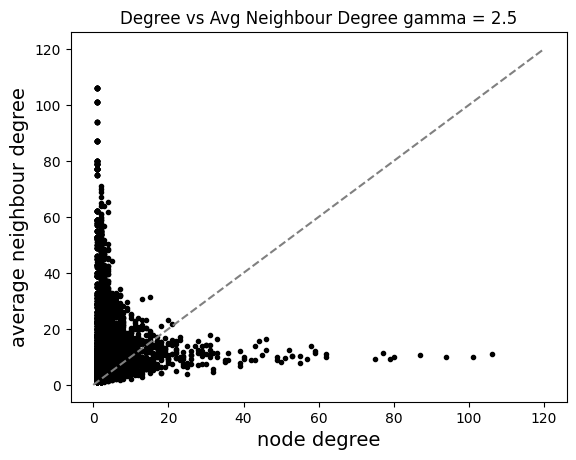

r = -0.006723789151568067


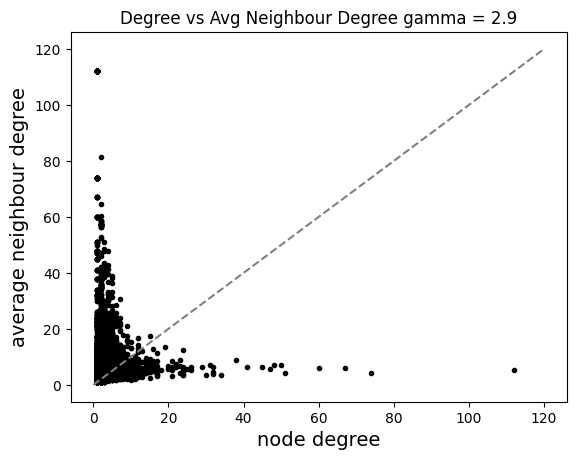

r = -0.019216717157750387


In [17]:
def get_nad_graph(g, title):
    LIM = 120
    nad = []
    deg = [v.degree() for v in g.vs()]

    for v in g.vs():
        nv = g.neighbors(v)
        nad.append(np.mean([deg[i] for i in nv]))

    plt.scatter(deg,nad,c='black',marker='.')    
    plt.title(title)
    plt.xlabel('node degree', fontsize=14)
    plt.ylabel('average neighbour degree', fontsize=14);    
    plt.plot([0,LIM],[0,LIM],'--', c='gray')
    plt.show()
    print('r =',g.assortativity_degree())

get_nad_graph(cl_2_1, "Degree vs Avg Neighbour Degree gamma = 2.1")
get_nad_graph(cl_2_5, "Degree vs Avg Neighbour Degree gamma = 2.5")
get_nad_graph(cl_2_9, "Degree vs Avg Neighbour Degree gamma = 2.9")
    

From our graphs we can see that the neighbour's average degree decreases as we increase the value of gamma. When gamma = 2.1 there are many high degree nodes, as indicated by the density of the points under our dotted unit line. This decreases as we increase our gamma, with the gamma = 2.5 and gamma = 2.9 graphs having progressively fewer high degree nodes. This makes sense, as for CL graphs increasing the value of gamma results in a smaller degree being generated for each vertex. This indicates that CL graphs with a larger gamma more strongly demonstrate the friendship paradox. 

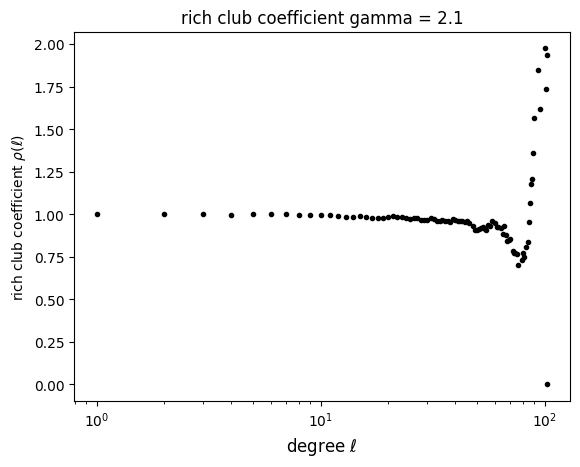

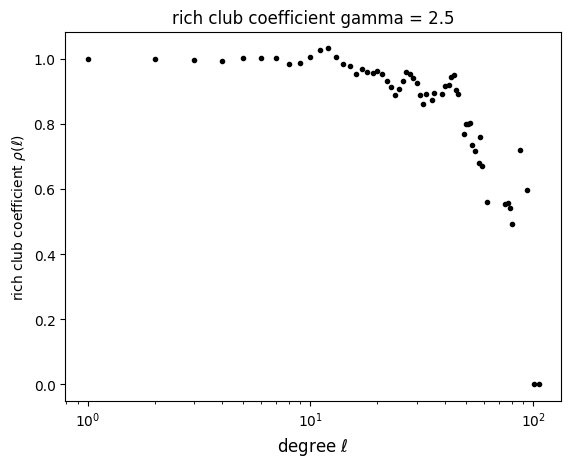

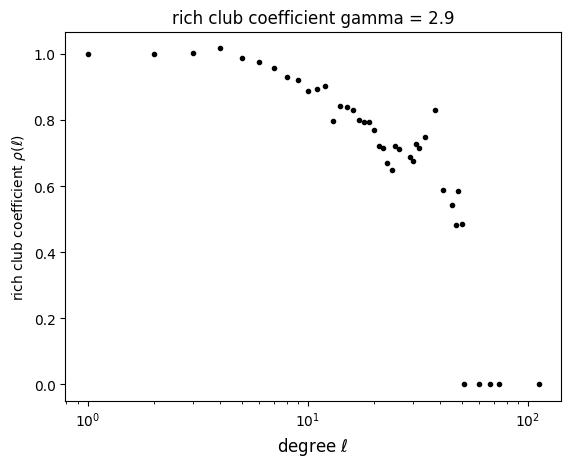

In [18]:
# ## still no rich club group here
get_rc_graph(cl_2_1, "rich club coefficient gamma = 2.1")
get_rc_graph(cl_2_5, "rich club coefficient gamma = 2.5")
get_rc_graph(cl_2_9, "rich club coefficient gamma = 2.9")

We can see as we increase the value of gamma, evidence of a presence of a rich club increases. For gamma = 2.1, the value of our rich club coefficient does not exceed 1, but as we increase the gamma value, we see more and more pronounced spikes in our graph, indicating that with a greater value of gamma, our "rich" nodes are more likely to be connected to nodes of a similar status. 